<a href="https://colab.research.google.com/github/corbittcoder/DS-Unit-1-Sprint-3-Statistical-Tests-and-Experiments/blob/master/module2-sampling-confidence-intervals-and-hypothesis-testing/LS_DS_132_Sampling_Confidence_Intervals_and_Hypothesis_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 132
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [2]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [3]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=46.24179655519528, pvalue=9.093298788095795e-11)


In [4]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## T-test Assumptions

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

- Independence of means

Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).


In [0]:
from scipy.stats import ttest_ind

?ttest_ind

- "Homogeneity" of Variance? 

Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test

In [0]:
?ttest_ind

- "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test. This problem typically goes away for large sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up. People declare the assumption to be satisfied either way. 



## Central Limit Theorem



In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

sample_means = []
for x in range(0,3000):
  coinflips = np.random.binomial(n=1, p=.5, size=12)
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means)

3000
[0.5, 0.6666666666666666, 0.25, 0.6666666666666666, 0.3333333333333333, 0.4166666666666667, 0.5, 0.4166666666666667, 0.4166666666666667, 0.5833333333333334, 0.16666666666666666, 0.3333333333333333, 0.4166666666666667, 0.5833333333333334, 0.5, 0.5, 0.5833333333333334, 0.3333333333333333, 0.5833333333333334, 0.4166666666666667, 0.5, 0.75, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.5, 0.5, 0.75, 0.5, 0.3333333333333333, 0.5, 0.75, 0.3333333333333333, 0.75, 0.4166666666666667, 0.3333333333333333, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.75, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.4166666666666667, 0.75, 0.5833333333333334, 0.5833333333333334, 0.25, 0.5833333333333334, 0.5, 0.5833333333333334, 0.75, 0.5, 0.5833333333333334, 0.3333333333333333, 0.5833333333333334, 0.5833333333333334, 0.3333333333333333, 0.5833333333333334, 0.25, 0.6666666666666666, 0.5, 0.25, 0.25, 0.4166666666666667, 0.4166666666666667, 0.8333333333333334, 0

In [8]:
df = pd.DataFrame({'a': one_sample})
df.head()

,a
0,0
1,1
2,1
3,1
4,0


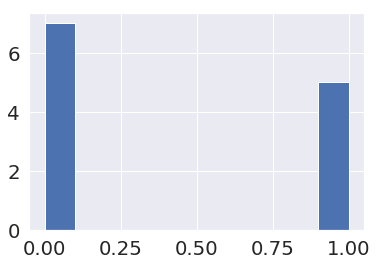

In [9]:
df.a.hist()

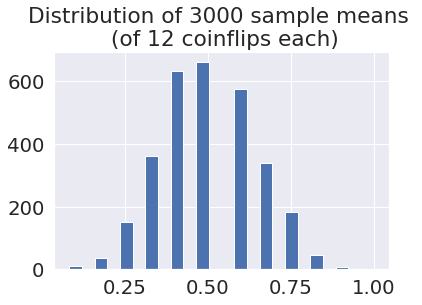

In [10]:
ax = plt.hist(sample_means, bins=24)
plt.title('Distribution of 3000 sample means \n (of 12 coinflips each)');

What does the Central Limit Theorem State? That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

In [11]:
coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
    
sample_std = np.std(coinflips_100, ddof=1)
print("sample standard dev", sample_std)

sample standard dev 0.5024183937956914


In [12]:
sample_size = len(coinflips_100)
print(sample_size)

100


In [13]:
standard_error = sample_std / np.sqrt(sample_size)

print("Standard Error", standard_error)

Standard Error 0.05024183937956914


In [14]:
from scipy import stats

stderr = stats.sem(coinflips_100, ddof=1)
print("Scipy standard error", stderr)

Scipy standard error 0.05024183937956914


##Look at stats.t.ppf()

In [15]:
t=stats.t.ppf(.975, 99) 
t

1.9842169515086827

In [16]:
t = stats.t.ppf(.025, 99)
t

-1.9842169515086832

In [17]:
(1+.99)/2

0.995

In [18]:
stats.t.ppf(.995, 99)

2.6264054563851857

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  sample_size = len(data)
  sample_std_dev = np.std(data, ddof=1)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, sample_size - 1)
  return (mean, mean - interval, mean + interval)

## Graphically Represent a Confidence Interval

https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html

https://jakevdp.github.io/PythonDataScienceHandbook/04.03-errorbars.html

https://seaborn.pydata.org/generated/seaborn.barplot.html

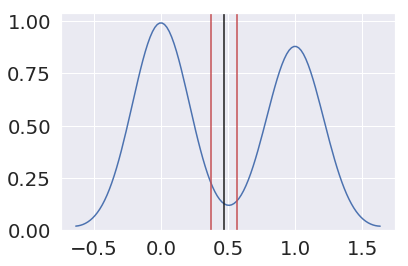

In [20]:
import seaborn as sns


coinflips_100 = np.random.binomial(n=1, p=.5, size=100)
sns.kdeplot(coinflips_100)
CI = confidence_interval(coinflips_100)
plt.axvline(x=CI[1], color='r')
plt.axvline(x=CI[2], color='r')
plt.axvline(x=CI[0], color='k')

## Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

In [0]:
from scipy.stats import t, ttest_1samp

In [22]:
import numpy as np

coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means)

[0.6, 0.5, 0.6333333333333333, 0.4, 0.4, 0.4666666666666667, 0.5333333333333333, 0.5333333333333333, 0.4, 0.5333333333333333, 0.3, 0.5333333333333333, 0.5333333333333333, 0.6, 0.5333333333333333, 0.6333333333333333, 0.4666666666666667, 0.5333333333333333, 0.5333333333333333, 0.43333333333333335, 0.4, 0.6, 0.36666666666666664, 0.6, 0.6, 0.5666666666666667, 0.4, 0.43333333333333335, 0.6333333333333333, 0.6333333333333333, 0.5333333333333333, 0.43333333333333335, 0.5333333333333333, 0.3333333333333333, 0.4666666666666667, 0.3333333333333333, 0.4, 0.4666666666666667, 0.6333333333333333, 0.43333333333333335, 0.36666666666666664, 0.5666666666666667, 0.5666666666666667, 0.6333333333333333, 0.4666666666666667, 0.6666666666666666, 0.36666666666666664, 0.36666666666666664, 0.36666666666666664, 0.5, 0.6666666666666666, 0.5333333333333333, 0.5, 0.43333333333333335, 0.5, 0.4666666666666667, 0.36666666666666664, 0.6333333333333333, 0.43333333333333335, 0.4666666666666667, 0.5666666666666667, 0.46666

In [23]:
# Sample Size
n = len(coinflip_means)
# Degrees of Freedom
dof = n-1
# The Mean of Means:
mean = np.mean(coinflip_means)
# Sample Standard Deviation
sample_std = np.std(coinflip_means, ddof=1)
# Standard Error
std_err = sample_std/n**.5

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.47229604845181783, 0.5097039515481822)


In [24]:
'''You can roll your own CI calculation pretty easily. 
The only thing that's a little bit challenging 
is understanding the t stat lookup'''

# 95% confidence interval
t_stat = t.ppf(.975, dof)
print("t Statistic:", t_stat)

CI = (mean-(t_stat*std_err), mean+(t_stat*std_err))
print("Confidence Interval", CI)

t Statistic: 1.9842169515086827
Confidence Interval (0.47229604845181783, 0.5097039515481822)


A null hypothesis that's just inside of our confidence interval == fail to reject



In [25]:
ttest_1samp(coinflip_means, .49)

Ttest_1sampResult(statistic=0.10608544116451862, pvalue=0.9157292253188959)

A null hypothesis that's just outside of our confidence interval == reject



In [26]:
ttest_1samp(coinflip_means, .4818927)

Ttest_1sampResult(statistic=0.966151938317618, pvalue=0.33632241031590215)

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [28]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [29]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [30]:
cut_points = [0,9,19,29,39,49,1000]
label_names = ['0-9', '10-19', '20-29', '30-39', '40-49', '50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,40-49
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,10-19
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,40-49
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,40-49
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,40-49


In [31]:
df['sex'].value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [32]:
df['hours_per_week_categories'].value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [33]:
df = df.sort_values(by='hours_per_week_categories')

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary,hours_per_week_categories
31290,55,Self-emp-not-inc,41938,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,8,United-States,<=50K,0-9
5172,32,NaN,134886,HS-grad,9,Married-civ-spouse,NaN,Wife,White,Female,0,0,2,United-States,>50K,0-9
22928,17,NaN,332666,10th,6,Never-married,NaN,Own-child,White,Female,0,0,4,United-States,<=50K,0-9
7902,35,Private,359131,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,White,Female,7298,0,8,NaN,>50K,0-9
6604,41,Private,406603,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,6,Iran,<=50K,0-9


In [34]:
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)

contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


In [35]:
femalecount = contingency_table.iloc[0][0:6].values
femalecount

array([ 235,  671, 1287, 1914, 5636, 1028])

In [36]:
malecount = contingency_table.iloc[1][0:6].values
malecount

array([  223,   575,  1105,  1753, 12700,  5434])

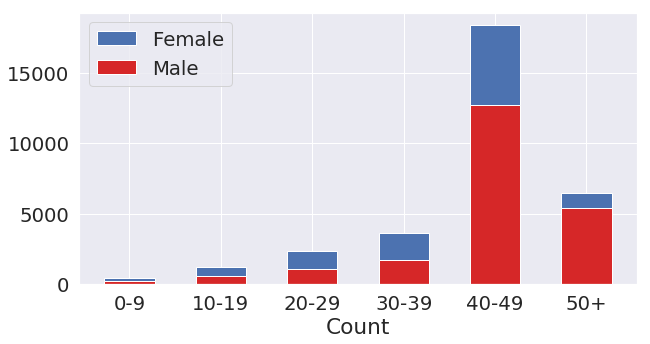

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

#plots the bar chart
fig = plt.figure(figsize=(10,5))
sns.set(font_scale=1.8)
categories = label_names
p1 = plt.bar(categories, malecount, .55, color='#d62728')
p2 = plt.bar(categories, femalecount, .55, bottom=malecount)
plt.legend((p2[0], p1[0]), ('Female', 'Male'))
plt.xlabel('Count')
plt.show()

##Expected Value Calculation

\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}



In [39]:
#Get Row sums
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values
print (row_sums)
print (col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [40]:
total = contingency_table.loc['All', 'All']
total

32561

In [41]:
len(df)

32561

In [42]:
 df.shape[0]

32561

In [43]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  
expected = np.array(expected)
print (expected.shape)
print (expected)

(2, 6)
[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


In [44]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
print(observed.shape)
observed

(2, 6)


array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

## Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [45]:
chi_squared = ((observed - expected)**2/expected).sum()
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 2287.190943926107


In [46]:
#Calculate Degrees of Freedom
dof = (len(row_sums) - 1) * (len(col_sums) - 1)
print(f"Degrees of Freedom: {dof}")

Degrees of Freedom: 5


## Run a $\chi^{2}$ Test using Scipy

In [47]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


### Conclusion
Based on a chi-squared statistic of 2287 and a p-value of 0. I reject the null hypothesis that hours_worked_per_week, and sex are independent, and suggest the alternative that there is an association between hours_worked_per_week and sex.